In [1]:
# Importing stuff
push!(LOAD_PATH, "/Users/robert/bio/BeNGS")
using Bio.Seq
using NGSutilsFuncs
using Distributions
using HMMIDMethods
using HMMIDConfig
using States
using Observations
using NeedlemanWunsch
using PyPlot
using StatsBase

In [2]:
# Where is the HMMIDs directory relative to where you're running your julia notebook?
print("Current path: $(pwd())")
path_to_hmmids = "./"

Current path: /Users/robert/bio/hmmids

"./"

# Making a simulated dataset

In [3]:
srand(1234)
sample_size = 1000

1000

In [4]:
sequences_in_fasta = []
for sequence in open(FASTAReader, "$(path_to_hmmids)data/P018_HQCS_short.fasta")
    push!(sequences_in_fasta, (sequence.name, replace(string(sequence.seq), "-", "")))
end

In [5]:
number_of_reads = 100000
original_templates = sample_size
pcr_cycles = 45
double = log(2)
pcr_efficiency = 0.7
dist = Binomial(pcr_cycles, pcr_efficiency)
molecules = e.^(rand(dist, (original_templates)) * double)
template_count = zeros(Int64, original_templates)
for molecule in wsample(1:original_templates, molecules, number_of_reads)
    template_count[molecule] += 1
end;
#bar(1:original_templates, template_count);

#g = Geometric(1/51)
#template_count = rand(g, sample_size)

In [6]:
# Generating our dataset using our samples as seeds
primer_before_pid = "GATTACA"
pid_length = 8
primer_after_pid = "ACGTACGTGGAAGACTTA"
i = 1
true_sequences = Array{String,1}()
generated_sequences = Array{Bio.Seq.SeqRecord{Bio.Seq.BioSequence{Bio.Seq.DNAAlphabet{4}},Bio.Seq.FASTQMetadata}}(sum(template_count))
generated_tag_counts = Dict()
tag_to_original_sequence = Dict()
generated_index = 1
generated_qualities = []
@time for k in template_count
    sequence = sample(sequences_in_fasta)
    pid = join(rand(["A", "C", "G", "T"], pid_length))
    template = ("$(primer_before_pid)$(pid)$(primer_after_pid)$(sequence[2])")
    push!(true_sequences, template)
    generated = envPBseqSim(template, k, withQVs=true)
    for j in 1:length(generated)
        label = "PID_$(i)_$(pid)_$(j)_of_$(k)"
        sequence = Bio.Seq.SeqRecord(label, DNASequence(generated[j][1]), Bio.Seq.FASTQMetadata("", map(prob -> Int8(round(-10*log10(prob))), generated[j][2])))
        generated_sequences[generated_index] = sequence
        push!(generated_qualities, generated[j][2])
        generated_index += 1
        if generated_index % 50000 == 0
            try
                run(`say -r 600 Generated $(generated_index) sequences`)
            end
        end
    end
    generated_tag_counts[pid] = k
    tag_to_original_sequence[pid] = template
    i += 1
end
#shuffle!(generated_sequences);

 12.629088 seconds (108.14 M allocations: 3.001 GB, 12.19% gc time)


In [7]:
println("$(length(generated_tag_counts) - length(Set(generated_tag_counts))) duplicates")

0 duplicates


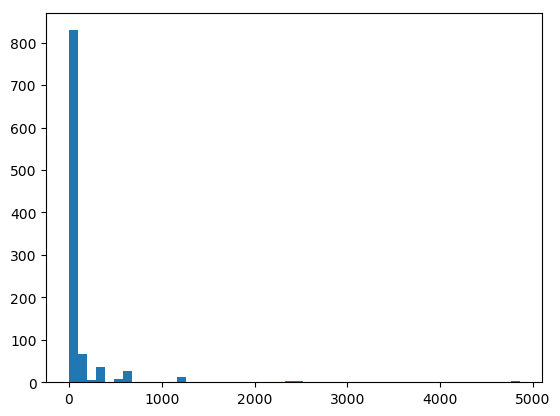

In [8]:
fig, ax = subplots()
ax[:hist](collect(values(generated_tag_counts)), 50);

# Running HMMIDS on Simulation Data

In [9]:
cfg = Configuration()
cfg.start_inclusive = 1
cfg.end_inclusive = length(primer_before_pid) + pid_length + length(primer_after_pid) + 5
cfg.try_reverse_complement = false
push!(cfg.templates, Template("Reference", "$(primer_before_pid)$(repeat("n", pid_length))$(primer_after_pid)*"))

1-element Array{HMMIDConfig.Template,1}:
 HMMIDConfig.Template("Reference",States.AbstractState[States.StartingState(),States.ObservableState(DNA_G),States.ObservableState(DNA_A),States.ObservableState(DNA_T),States.ObservableState(DNA_T),States.ObservableState(DNA_A),States.ObservableState(DNA_C),States.ObservableState(DNA_A),States.BarcodeState(DNA_N),States.BarcodeState(DNA_N)  …  States.ObservableState(DNA_G),States.ObservableState(DNA_A),States.ObservableState(DNA_A),States.ObservableState(DNA_G),States.ObservableState(DNA_A),States.ObservableState(DNA_C),States.ObservableState(DNA_T),States.ObservableState(DNA_T),States.ObservableState(DNA_A),States.RepeatingAnyState(DNA_N)])

In [10]:
tag_dict = Dict()

# This is the slow bit
@time for sequence in generated_sequences
    seq, quality = slice_sequence(sequence, cfg.start_inclusive, -1, cfg.end_inclusive, -1, false)
    
    score, tag, errors = NeedlemanWunsch.extract_tag(seq, quality, cfg.templates[1].reference)
    
    tag = length(tag) > 0 ? string(tag) : "NO_TAG"
    tag = errors <= cfg.max_allowed_errors ? tag : "REJECTS"
    if !haskey(tag_dict, tag)
        tag_dict[tag] = []
    end
    push!(tag_dict[tag], (score, sequence))
end

 35.410576 seconds (510.96 M allocations: 9.270 GB, 6.62% gc time)


In [11]:
real_tags = Set()
observed_tags = Set()
for observed_label in keys(tag_dict)
    for (score, sequence) in tag_dict[observed_label]
        real_label = split(sequence.name, "_")[3]
        push!(real_tags, real_label)
        push!(observed_tags, observed_label)
    end
end

In [12]:
tag_counts = Dict() 
tags = []
index = 1
for tag in keys(tag_dict)
    push!(tags, tag)
    tag_counts[tag] = length(tag_dict[tag])
end

# Resolving which tags are real

In [13]:
using Resolving
recurse = 1
pacbio_error_rate = 0.001
tag_to_index, index_to_tag = tag_index_mapping(tags)
@time probabilities_array = prob_observed_tags_given_reals(tag_to_index, Resolving.PacBioErrorModel(pacbio_error_rate), recurse)
indexed_counts = index_counts(tag_counts, tag_to_index);

 10.710648 seconds (76.20 M allocations: 3.396 GB, 24.42% gc time)


In [14]:
using CustomLDA
dirichlet_concentration = 0.5
most_likely_real_for_each_obs = CustomLDA.LDA(probabilities_array, indexed_counts, concentration=dirichlet_concentration);

In [15]:
minimum_bin_size = 1
likely_real = []
tag_to_prob = Dict()
for (observed_index, tuple) in enumerate(most_likely_real_for_each_obs)
    prob = tuple[2]
    if tag_counts[index_to_tag[observed_index]] <= minimum_bin_size
        prob = 0
    end
    if observed_index != tuple[1]
        prob = 0
    end
    tag_to_prob[index_to_tag[observed_index]] = prob
    push!(likely_real, (prob, index_to_tag[observed_index]))
end
sort!(likely_real)

2571-element Array{Any,1}:
 (0,"AAAACCCA")  
 (0,"AAAAGAAA")  
 (0,"AAAAGAAG")  
 (0,"AAAAGAGC")  
 (0,"AAAAGCTTG") 
 (0,"AAAAGGGG")  
 (0,"AAAAGTAG")  
 (0,"AAAAGTGA")  
 (0,"AAAAGTTG")  
 (0,"AAAATAGG")  
 (0,"AAAATTGG")  
 (0,"AAACAGGG")  
 (0,"AAACAGGGG") 
 ⋮               
 (1.0,"CATGCGCT")
 (1.0,"CTACACTG")
 (1.0,"GATATCAA")
 (1.0,"GCAGTGGA")
 (1.0,"GCATCGGC")
 (1.0,"GCCGACGA")
 (1.0,"GGGAAGCG")
 (1.0,"TACCGCTA")
 (1.0,"TCTGCAGT")
 (1.0,"TTGATGGA")
 (1.0,"TTGTCCGG")
 (1.0,"TTTTTGAC")

In [16]:
count_tag = []
for tag in keys(tag_counts)
    push!(count_tag, (tag_counts[tag], tag))
end
sort!(count_tag)

2571-element Array{Any,1}:
 (1,"AAAACCCA")   
 (1,"AAAAGAAA")   
 (1,"AAAAGAAG")   
 (1,"AAAAGAGC")   
 (1,"AAAAGCTTG")  
 (1,"AAAAGGGG")   
 (1,"AAAAGTAG")   
 (1,"AAAAGTGA")   
 (1,"AAAAGTTG")   
 (1,"AAAATAGG")   
 (1,"AAAATTGG")   
 (1,"AAACAGGG")   
 (1,"AAACAGGGG")  
 ⋮                
 (1194,"AGAAGTGT")
 (1195,"ACGGACGG")
 (1216,"TGTTATGT")
 (1245,"AGATAAGG")
 (2283,"AGATCCCG")
 (2320,"GTCGCGCT")
 (2357,"TCGATCAA")
 (2363,"TTTGCTTA")
 (2404,"GTGGATGT")
 (2405,"GTTTCCGC")
 (4736,"GTAGTCCT")
 (4740,"ACTCCTCG")

In [17]:
function false_pos_neg_graph(pairs, real_tags)
    false_positive_count = 0
    true_positive_count = 0
    for (value, tag) in pairs
        if (tag in real_tags)
            true_positive_count += 1
        else
            false_positive_count += 1
        end
    end
    x_values = [false_positive_count]
    y_values = [true_positive_count]
    for (value, tag) in pairs
        if tag in real_tags
            true_positive_count -= 1
        else
            false_positive_count -= 1
        end
        push!(x_values, false_positive_count)
        push!(y_values, true_positive_count)
    end
    return x_values, y_values
end

false_pos_neg_graph (generic function with 1 method)

In [18]:
function filter_out_same_values(sorted_values, dependant_variable)
    out = [dependant_variable[1]]
    last_value = 0
    for i in 1:length(sorted_values)
        if sorted_values[i] > last_value
            push!(out, dependant_variable[i+1])
            last_value = sorted_values[i]
        end
    end
    return out
end

filter_out_same_values (generic function with 1 method)

In [19]:
x_us, y_us = false_pos_neg_graph(likely_real, real_tags) 
x_us = filter_out_same_values([x[1] for x in likely_real], x_us)
y_us = filter_out_same_values([x[1] for x in likely_real], y_us)
short_likely_real = vcat([0.], [x[1] for x in likely_real])
short_likely_real = filter_out_same_values([x[1] for x in likely_real], short_likely_real)

x_ron, y_ron = false_pos_neg_graph(count_tag, real_tags)
x_ron = filter_out_same_values([x[1] for x in count_tag], x_ron)
y_ron = filter_out_same_values([x[1] for x in count_tag], y_ron)
short_count_tag = vcat([0], [x[1] for x in count_tag]) 
short_count_tag = filter_out_same_values([x[1] for x in count_tag], short_count_tag);

In [20]:
type GraphVariables 
    sample_size
    number_of_reads
    recurse
    pacbio_error_rate
    dirichlet_concentration
    pcr_cycles
    pcr_efficiency
    minimum_bin_size
end
GraphVariables() = GraphVariables(1000,100000,1,0.005,0.5,45,0.7,1)
function GraphVariables(symbols::Array{Symbol}, values::Array{Any})
    gv = GraphVariables()
    for (symbol, value) in zip(symbols, values)
        setfield!(gv, symbol, value)
    end
    return gv
end

GraphVariables

In [21]:
# Read from file
filename = "BioSeqComparison.csv"
plots = Dict()
variables = fieldnames(GraphVariables())
if isfile(filename)
    file = open(filename)
    variables = map(Symbol, split(strip(readline(file)), ","))
    info(variables)
    number_of_plots = parse(strip(readline(file)))
    info("Reading $(number_of_plots) existing plots from file")
    for i in 1:number_of_plots
        parameters = map(parse, split(strip(readline(file)),","))
        our_threshold = map(parse, split(strip(readline(file)),","))
        our_x = map(parse, split(strip(readline(file)),","))
        our_y = map(parse, split(strip(readline(file)),","))
        rons_threshold = map(parse, split(strip(readline(file)),","))
        rons_x = map(parse, split(strip(readline(file)),","))
        rons_y = map(parse, split(strip(readline(file)),","))
        plots[parameters] = (our_threshold, our_x, our_y, rons_threshold, rons_x, rons_y)
    end
end;

INFO: Symbol[:sample_size,:number_of_reads,:recurse,:pacbio_error_rate,:dirichlet_concentration,:pcr_cycles,:pcr_efficiency,:minimum_bin_size]
INFO: Reading 1 existing plots from file


LoadError: ParseError("extra token \"]\" after end of expression")

In [22]:
plots[map(eval, variables)] = (short_likely_real, x_us, y_us, short_count_tag, x_ron, y_ron);
println("$(length(plots)) plots")

1 plots


In [33]:
# Write to file
parameters = 
file = open(filename, "w")
write(file, "$(join(variables, ","))\n")
write(file, "$(length(plots))\n")
for (key, values) in plots
    write(file, "$(join(key, ","))\n") # The values of the parameters for the plot
    write(file, "$(join(values[1], ","))\n") # Our threshold values
    write(file, "$(join(values[2], ","))\n") # Our x values
    write(file, "$(join(values[3], ","))\n") # Our y values
    write(file, "$(join(values[4], ","))\n") # Ron's threshold values
    write(file, "$(join(values[5], ","))\n") # Ron's x values
    write(file, "$(join(values[6], ","))\n") # Ron's y values
    write(file, "\n")
end
close(file)

0.9 - 278 false positive, 820 true positive (out of 993)


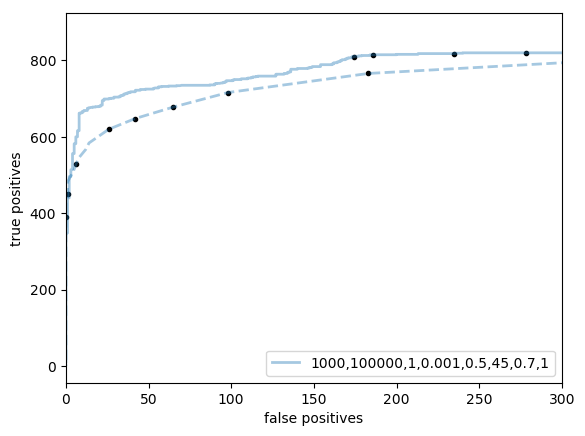

0.95 - 235 false positive, 818 true positive (out of 993)
0.99 - 186 false positive, 815 true positive (out of 993)
0.995 - 174 false positive, 810 true positive (out of 993)


In [24]:
fig, ax = subplots()

# Printing points for the different special thresholds
# Ben's threshold points
threshold = [.9, .95, .99, .995, 100]
threshold_i = 1
for i in 1:length(short_likely_real)
    if short_likely_real[i][1] > threshold[threshold_i]
        ax[:plot](x_us[i], y_us[i], ".", color="black", )
        println("$(threshold[threshold_i]) - $(x_us[i]) false positive, $(y_us[i]) true positive (out of $(length(generated_tag_counts)))")
        threshold_i += 1
    end
end
# Ron's 
threshold = [1, 2, 3, 4, 5, 10, 15, 20, 10000000]
threshold_i = 1
for i in 1:length(short_count_tag)
    if short_count_tag[i][1] > threshold[threshold_i]
        ax[:plot](x_ron[i+1], y_ron[i+1], ".", color="black")
        threshold_i += 1
    end
end

# Plotting the plots from the save file, as well as our new plots
for (parameters, values) in plots
    parms = ax[:plot](values[2], values[3], linewidth=2, label="$(join(parameters,","))", alpha=0.4)
    chosen_color = parms[1][:get_color]()
    ax[:plot](values[5], values[6], linestyle="--", linewidth=2, color=chosen_color, alpha=0.4)
end

ax[:legend](loc=4)
xlim([0,300])
#ylim([1500,2000])
#ylim([700,900])
xlabel("false positives")
ylabel("true positives");


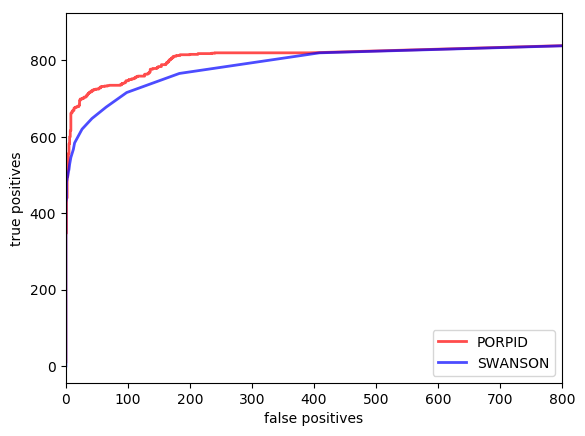

0.9 - 278 false positive, 820 true positive (out of 993)
0.95 - 235 false positive, 818 true positive (out of 993)
0.99 - 186 false positive, 815 true positive (out of 993)
0.995 - 174 false positive, 810 true positive (out of 993)


In [25]:
# Printing for the proposal
fig, ax = subplots()

# Printing points for the different special thresholds
# Ben's threshold points
threshold = [.9, .95, .99, .995, 100]
threshold_i = 1
for i in 1:length(short_likely_real)
    if short_likely_real[i][1] > threshold[threshold_i]
        #ax[:plot](x_us[i], y_us[i], ".", color="red")
        println("$(threshold[threshold_i]) - $(x_us[i]) false positive, $(y_us[i]) true positive (out of $(length(generated_tag_counts)))")
        threshold_i += 1
    end
end
# Ron's 
threshold = [1, 2, 3, 4, 5, 10, 15, 20, 10000000]
threshold_i = 1
for i in 1:length(short_count_tag)
    if short_count_tag[i][1] > threshold[threshold_i]
        #ax[:plot](x_ron[i+1], y_ron[i+1], ".", color="blue")
        threshold_i += 1
    end
end

(map(eval, variables), short_likely_real, x_us, y_us, short_count_tag, x_ron, y_ron)
ax[:plot](x_us, y_us, linewidth=2, color="red", label="PORPID", alpha=0.7)
ax[:plot](x_ron, y_ron, linewidth=2, color="blue", label="SWANSON", alpha=0.7)

ax[:legend](loc=4)
xlim([0,800])
#ylim([1500,2000])
#ylim([700,900])
xlabel("false positives")
ylabel("true positives");


In [26]:
threshold = 0.95
included = Set()
excluded = Set()
for (prob, tag) in likely_real
    if prob >= threshold
        push!(included, tag)
    else
        push!(excluded, tag)
    end
end

In [27]:
# Of the initial number of tags, how many are recovered?
recovered_tags = 0
for generated_tag in keys(generated_tag_counts)
    if generated_tag in included
        recovered_tags += 1
    end
end
println("Of the $(length(generated_tag_counts)) original tags, $(recovered_tags) were recovered")

Of the 993 original tags, 819 were recovered


ACTCTTCG - 4 generated copies - 5 seen copies - 0.9422261 probability of being real


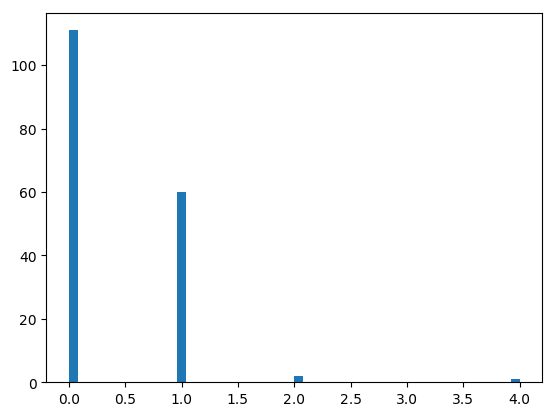

	ACTCTTCG - 5 seen copies - 0.99202794 chance of indel
	ACTCCTTCG - 1 seen copies - 0.00019839381 chance of indel
	ACTCCTCG - 4740 seen copies - 6.6539644f-5 chance of indel
	ACTCATCG - 6 seen copies - 6.637965f-5 chance of indel
	ACTCGTCG - 2 seen copies - 6.637964f-5 chance of indel
	ACTTCTCG - 1 seen copies - 4.088889f-7 chance of indel
	ACCTCTCG - 1 seen copies - 4.0f-7 chance of indel
	AACTCTCG - 15 seen copies - 3.2f-7 chance of indel
	ACTGCTCG - 3 seen copies - 1.6888889f-7 chance of indel
	ACTCCTTG - 2 seen copies - 1.6888889f-7 chance of indel
	AACCTTCG - 33 seen copies - 1.6888889f-7 chance of indel
	ACTACTCG - 1 seen copies - 1.6888889f-7 chance of indel
	CTCCTTCG - 5 seen copies - 1.6f-7 chance of indel
	AACTCTTC - 2 seen copies - 1.6f-7 chance of indel
	ACCTCTTC - 598 seen copies - 1.6f-7 chance of indel
	AGCCTTCG - 2 seen copies - 8.888889f-8 chance of indel
	ACTCTATC - 1 seen copies - 8.0f-8 chance of indel
	ATCTCTTC - 1 seen copies - 8.0f-8 chance of indel
	TACTCTTG - 1

In [28]:
# Of the unrecovered tags, how many copies were generated
unrecovered_copy_count = []
but = "None"
buts = 0
for generated_tag in keys(generated_tag_counts)
    if !(generated_tag in included)
        push!(unrecovered_copy_count, generated_tag_counts[generated_tag])
        if generated_tag_counts[generated_tag] > buts
            buts = generated_tag_counts[generated_tag]
            but = generated_tag
        end
    end
end
fig, ax = subplots()
ax[:hist](unrecovered_copy_count, 50);
println("$(but) - $(buts) generated copies - $(tag_counts[but]) seen copies - $(tag_to_prob[but]) probability of being real")
for (index, prob) in sort!(probabilities_array[tag_to_index[but]], by=x->-x[2])
    println("\t$(index_to_tag[index]) - $(tag_counts[index_to_tag[index]]) seen copies - $(prob) chance of indel")
end


In [29]:
# Of the recovered tags, how many are valid?
valid_tags = 0
for recovered_tag in included
    if recovered_tag in keys(generated_tag_counts)
        valid_tags += 1
    end
end
println("Of the $(length(included)) recovered tags, $(valid_tags) were valid, with a false positive rate of $(round((length(included)-valid_tags)/length(included)*100,4))%")

Of the 1054 recovered tags, 819 were valid, with a false positive rate of 22.296%


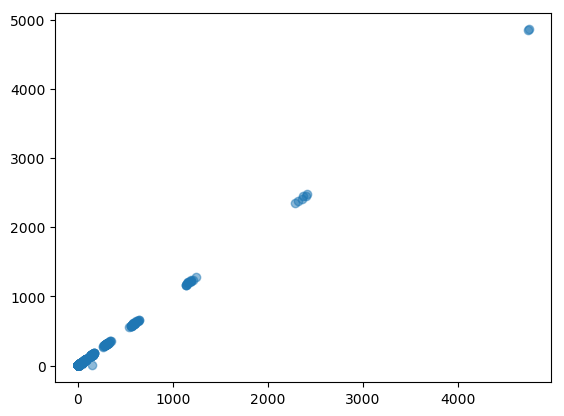

In [30]:
# Of the validly recovered tags, how many of the original sequences are recovered
recovered = []
out_of = []
for recovered_tag in included
    if recovered_tag in keys(generated_tag_counts)
        matching = 0
        for sequence in tag_dict[recovered_tag]
            real_label = split(sequence[2].name, "_")[3]
            if real_label == recovered_tag
                matching += 1
            end
        end
        push!(recovered, matching)
        push!(out_of, generated_tag_counts[recovered_tag])
    end
end
scatter(recovered, out_of, alpha=0.5);

In [31]:
# Of the validly recovered tags, how many mismatched sequences are included
for recovered_tag in included
    if recovered_tag in keys(generated_tag_counts)
        non_matching = 0
        for sequence in tag_dict[recovered_tag]
            real_label = split(sequence[2].name, "_")[3]
            if real_label != recovered_tag
                non_matching += 1
            end
        end
        if non_matching > 0
            println("$(non_matching) out of $(length(tag_dict[recovered_tag])) mismatched tags for $(recovered_tag)")
        end
    end
end

1 out of 2 mismatched tags for CCCTCCCA
1 out of 45 mismatched tags for AGAGTTGA
1 out of 82 mismatched tags for TAGTGGAC
1 out of 4 mismatched tags for GGCTACCA
1 out of 20 mismatched tags for TATGGGCT
1 out of 71 mismatched tags for CTAACAGA
1 out of 164 mismatched tags for AACAGTTC
2 out of 3 mismatched tags for GTAAGTGA
4 out of 21 mismatched tags for ACTGAAGC
3 out of 18 mismatched tags for TTTCTTAA
2 out of 9 mismatched tags for AGCTAAGG
1 out of 42 mismatched tags for ACGCTACA
3 out of 4 mismatched tags for ATTTGGCT
1 out of 13 mismatched tags for GAACGAGA
1 out of 25 mismatched tags for TAATTAGT
1 out of 305 mismatched tags for GGTTTGAA
1 out of 8 mismatched tags for TTCGGGGG
1 out of 10 mismatched tags for TCGGTCAA
1 out of 2 mismatched tags for TAACGGAG


# Getting consensuses

edit_distances = []
number_of_copies = []
consensuses = []
for recovered_tag in included
    if !(recovered_tag in keys(tag_to_original_sequence))
        println("$(recovered_tag) not actually an original tag")
        continue
    end
    sequences = map(x -> x[2][2], tag_dict[recovered_tag])
    consensus_seq = consensusSeq(sequences)
    push!(consensuses, consensus_seq)
    original = tag_to_original_sequence[recovered_tag]
    distance = kmerSeededEditDist(consensus_seq, original)
    push!(edit_distances, distance)
    push!(number_of_copies, generated_tag_counts[recovered_tag])
    #println("$(recovered_tag) recovered with $((length(original) - distance) / length(original) * 100)% accuracy")
end

sum(edit_distances)

scatter(log(Array{Float64}(number_of_copies))+randn(length(edit_distances))*0.1, edit_distances+randn(length(edit_distances))*0.1, alpha = 0.1);